<a href="https://colab.research.google.com/github/diwakarojha/Tensorflow_Keras/blob/main/4_Time_Series_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense

In [116]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

In [117]:
def trend(time,slope=0):
  return slope * time

In [118]:
def seasonal_pattern(season_time):
  return np.where(season_time<0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))

In [119]:
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

In [120]:
def white_noise(time, noise_level=1, seed= None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level 

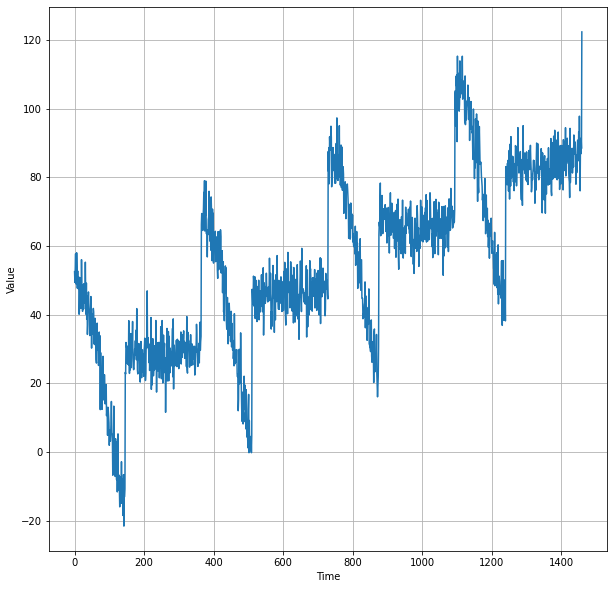

In [121]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40

series= baseline + trend(time,slope) + seasonality(time, period=365, amplitude=amplitude )

noise_level = 5
noise = white_noise(time, noise_level, seed= 42)

series += noise

plt.figure(figsize=(10,10))
plot_series(time, series)
plt.show()

In [122]:
series[:10]

array([52.48357077, 49.35275206, 53.31473872, 57.71182193, 48.93444534,
       48.93124221, 57.98289687, 53.89712254, 47.67392616, 52.68370684])

In [123]:
def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [124]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

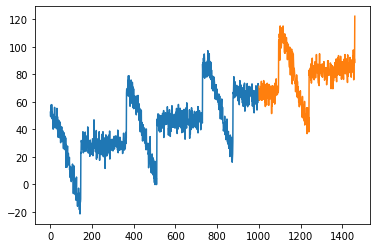

In [125]:
plt.plot(time_train,x_train)
plt.plot(time_valid,x_valid)

# Linear Model

In [126]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

In [ ]:
model=tf.keras.Sequential(
    [Dense(1, input_shape=[window_size])]
)

optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss= tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

model.fit(train_set,epochs=100, validation_data=valid_set)

In [ ]:
model=tf.keras.Sequential(
    [Dense(1, input_shape=[window_size])]
)

optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
lr_scheduler=tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-6 *10**(epoch/30))

model.compile(loss= tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history=model.fit(train_set,epochs=100, validation_data=valid_set, callbacks=[lr_scheduler])

(1e-06, 0.001, 0.0, 20.0)

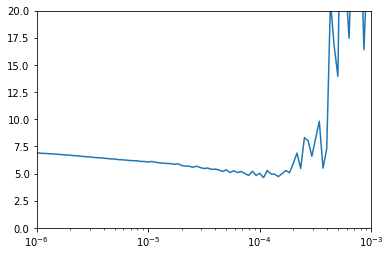

In [79]:
# Looking at graph we can say learning rate of 1e-5 looks good. anything between 1e-4 to 1e-5
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-6,1e-3,0,20])

In [ ]:
model=tf.keras.Sequential(
    [Dense(1, input_shape=[window_size])]
)

optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
early_stop=tf.keras.callbacks.EarlyStopping(patience=10)

model.compile(loss= tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history=model.fit(train_set,epochs=200, validation_data=valid_set, callbacks=[early_stop])

In [81]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast= model.predict(ds)
  return forecast

In [82]:
lin_forecast = model_forecast(model,series[split_time-window_size:-1], window_size)[:,0]

In [83]:
lin_forecast.shape

(461,)

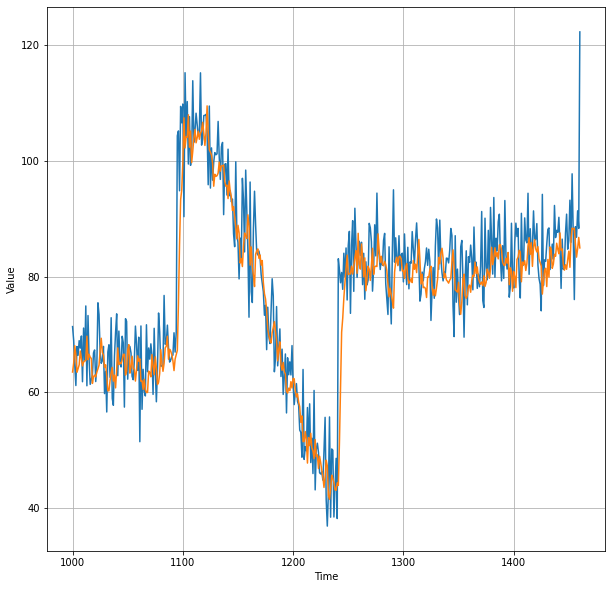

In [84]:
plt.figure(figsize=(10,10))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [85]:
tf.keras.metrics.mean_absolute_error(x_valid,lin_forecast)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9945517>

In [ ]:
model=tf.keras.Sequential(
    [Dense(10, input_shape=[window_size]),
     Dense(1, input_shape=[window_size])]
)

optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
early_stop=tf.keras.callbacks.EarlyStopping(patience=10)

model.compile(loss= tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history=model.fit(train_set,epochs=200, validation_data=valid_set, callbacks=[early_stop])

In [87]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

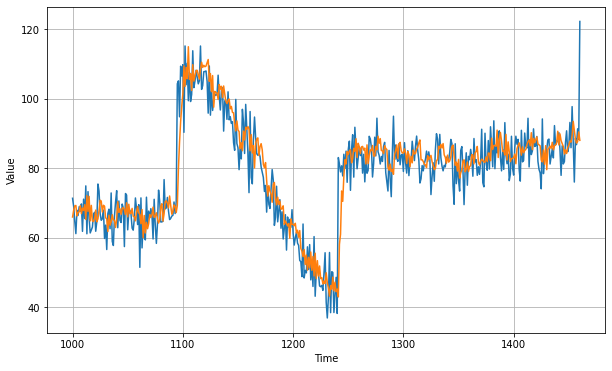

In [88]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [89]:
tf.keras.metrics.mean_absolute_error(x_valid,lin_forecast)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9945517>

In [99]:
for x,label in train_set.take(1):
  break

In [102]:
x[0].numpy(),label

(array([75.89651065, 71.05770114, 63.20005325, 61.36063214, 68.06966322,
        58.75557783, 74.25011869, 70.71560399, 62.18769731, 55.67276799,
        70.70246271, 63.04496227, 69.48131243, 54.98478194, 59.61496863,
        62.28333697, 62.12776733, 59.26887679, 64.25051304, 55.4060682 ,
        59.63115862, 60.53453232, 62.08649516, 62.64500983, 53.02788851,
        50.53636468, 64.14297567, 58.95578598, 53.08352715, 64.10573676]),
 <tf.Tensor: shape=(32,), dtype=float64, numpy=
 array([ 56.44479609,   2.11829782,  27.54128489,  50.15069825,
         53.09067835,   4.53872226,  65.27865278,  33.87169104,
         43.57180334,  40.23226006,  42.96352355,  50.37808041,
         68.41920094,  47.25254438,   6.26470837,  64.17726483,
         40.77832754,  30.59517496,  26.67721682,  83.09848971,
         66.44625906,  81.65220968,  36.41734379,  49.8063698 ,
         53.31405148,  77.6910381 ,  12.50641846, -11.1787106 ,
         33.460187  ,  47.68153279,  42.31935663,  69.47453262])

# Using RNNs

In [109]:
tf.keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(series,window_size,batch_size=128)

model=tf.keras.Sequential(
    [tf.keras.layers.Lambda( lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
     tf.keras.layers.SimpleRNN(100,return_sequences=True),
     tf.keras.layers.SimpleRNN(100),
     tf.keras.layers.Dense(1),
     tf.keras.layers.Lambda(lambda x : x * 200)
     ]
)

optimizer=tf.keras.optimizers.SGD(lr=1e-6,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

early_stop=tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoint=tf.keras.callbacks.ModelCheckpoint("model_checkpoint",save_best_only=True)

history=model.fit(train_set,validation_data=valid_set,epochs=500,callbacks=[early_stop, model_checkpoint])

12/12 [==============================] - 1s 47ms/step - loss: 6.0409 - mae: 6.5205 - val_loss: 6.0175 - val_mae: 6.5010
Epoch 49/500
12/12 [==============================] - 1s 44ms/step - loss: 6.0480 - mae: 6.5268 - val_loss: 7.0573 - val_mae: 7.5451
Epoch 50/500
12/12 [==============================] - 1s 43ms/step - loss: 6.9052 - mae: 7.3875 - val_loss: 10.5541 - val_mae: 11.0505
Epoch 51/500
12/12 [==============================] - 1s 48ms/step - loss: 6.7245 - mae: 7.2043 - val_loss: 4.7752 - val_mae: 5.2550
Epoch 52/500
12/12 [==============================] - 1s 45ms/step - loss: 6.1488 - mae: 6.6328 - val_loss: 4.6726 - val_mae: 5.1518
Epoch 53/500
12/12 [==============================] - 1s 44ms/step - loss: 5.8786 - mae: 6.3610 - val_loss: 5.3277 - val_mae: 5.8051
Epoch 54/500
12/12 [==============================] - 1s 47ms/step - loss: 6.0520 - mae: 6.5332 - val_loss: 5.9561 - val_mae: 6.4350
Epoch 55/500
12/12 [==============================] - 1s 44ms/step - loss: 6.485

In [110]:
model=tf.keras.models.load_model("model_checkpoint")

In [111]:
rnn_forecast= model_forecast(model,series[split_time - window_size:-1],window_size)[:,0]

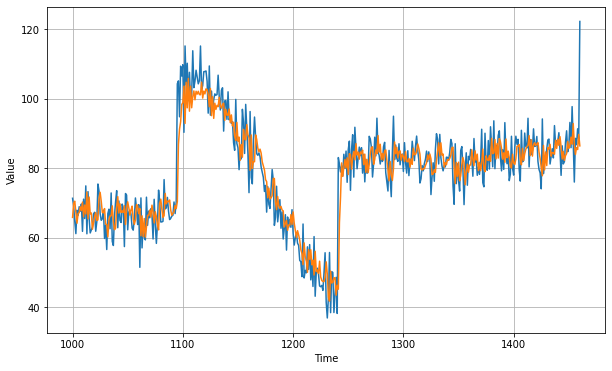

In [112]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [114]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.0974884

In [127]:
def seq2seq_window_dataset(series, window_size, batch_size = 32,
                           shuffle_buffer = 1000):
  series= tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)


In [132]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
  print("X:", X_batch.numpy())
  print("Y:", Y_batch.numpy())

X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]


In [136]:
tf.keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(series,window_size,batch_size=128)
valid_set = seq2seq_window_dataset(series,window_size,batch_size=128)

model=tf.keras.Sequential(
    [#tf.keras.layers.Lambda( lambda x: tf.expand_dims(x, axis=-1), input_shape=[None,1]),
     tf.keras.layers.SimpleRNN(100,return_sequences=True),
     tf.keras.layers.SimpleRNN(100,return_sequences=True),
     tf.keras.layers.Dense(1),
     tf.keras.layers.Lambda(lambda x : x * 200.0)
     ]
)

optimizer=tf.keras.optimizers.SGD(lr=1e-6,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

early_stop=tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoint=tf.keras.callbacks.ModelCheckpoint("model_checkpoint",save_best_only=True)

history=model.fit(train_set,validation_data=valid_set,epochs=500,callbacks=[early_stop, model_checkpoint])

Epoch 1/500

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

     11/Unknown - 0s 34ms/step - loss: 50.9029 - mae: 51.4011INFO:tensorflow:Assets written to: model_checkpoint/assets
12/12 [==============================] - 4s 295ms/step - loss: 50.6961 - mae: 51.1943 - val_loss: 36.9685 - val_mae: 37.4660
Epoch 2/500
12/12 [==============================] - 4s 294ms/step - loss: 28.0673 - mae: 28.5632 - val_loss: 23.4947 - val_mae: 23.9896
Epoch 3/500
12/12 [==============================] - 3s 285ms/step - loss: 17.8847 - mae: 18.3769 - val_loss: 15.6

In [137]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

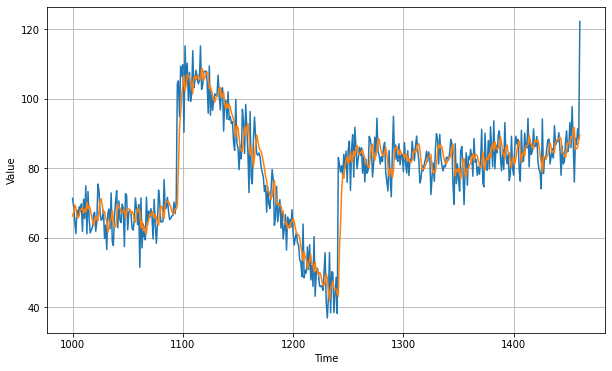

In [138]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [140]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

4.867112